### Libraries to import

In [229]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import cv2

In [230]:
path1 = "_images/virtual_landscape.jpg"
path2 = "_images/cute_cat.jpg"
path3 = "_images/25_abril.webp"
path4 = "_images/black_white_flower.webp"
path5 = "_images/s2_lisbon_.jpg"

## 1. Load an image

### Read and load the data

In [231]:
dataset = rasterio.open(path5)
img = dataset.read() 
print("Type:", type(img))  
print("Shape:", img.shape)       
print("Width:", img.shape[2])
print("Height:", img.shape[1])
print("Number of bands:", img.shape[0])
print("Dtype:", img.dtype)

Type: <class 'numpy.ndarray'>
Shape: (3, 634, 946)
Width: 946
Height: 634
Number of bands: 3
Dtype: uint8


/opt/anaconda3/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [232]:
band1 = dataset.read(1)
band2 = dataset.read(2)
band3 = dataset.read(3)
bands = [band1, band2, band3]
band = bands[0]

### Visualize RGB and greyscale images

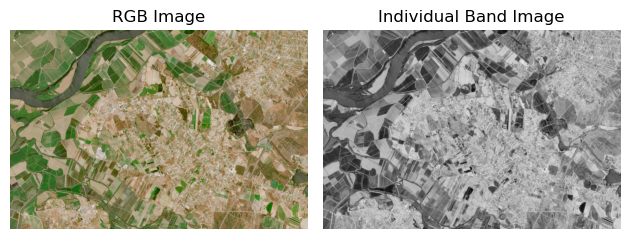

In [233]:
rgb = np.dstack((band1, band2, band3))

fig, axes = plt.subplots(1, 2)  

axes[0].imshow(rgb)  
axes[0].set_title("RGB Image")   
axes[0].axis('off')

axes[1].imshow(band, cmap='gray')  
axes[1].set_title("Individual Band Image")   
axes[1].axis('off')

plt.tight_layout()
plt.show()


## 2. Compute the negative of an image

### Negative band computation

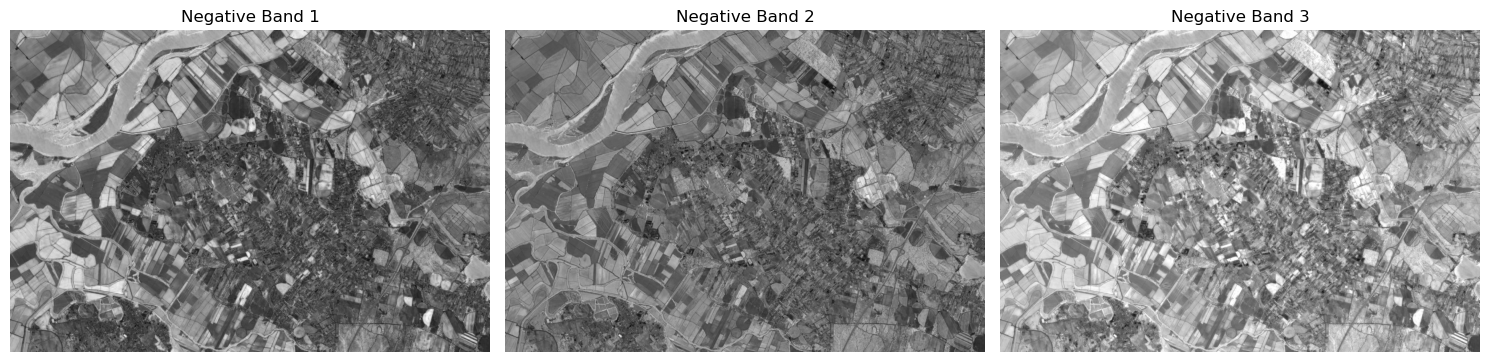

In [234]:
negative_bands = []
for i in bands:
    negative_bands.append((255 - i).astype(np.uint8))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

for i in range(3):
    axes[i].imshow(negative_bands[i], cmap='gray')  
    axes[i].set_title(f"Negative Band {i+1}")   
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Negative RGB image computation

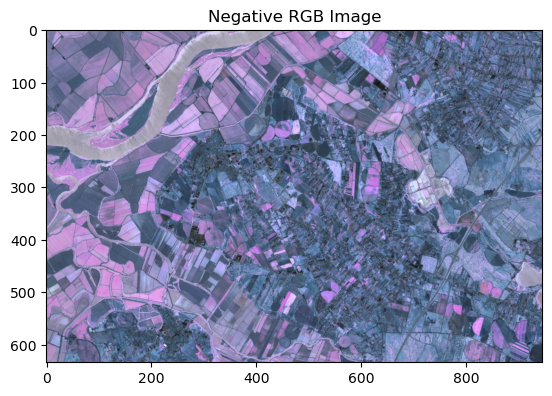

In [235]:
negative_rgb = np.dstack((negative_bands[0], negative_bands[1], negative_bands[2]))

plt.imshow(negative_rgb)
plt.title("Negative RGB Image")
plt.show()


## 3. Without & with a LUT, apply a gamma correction (report the eficiency gain)

### Gamma correction without LUT

In [236]:
%%time
gamma = 0.5
c = 255 # ensures that this value will be the max value for pixels
# gamma < 1 brightens the image
# # gamma > 1 darkens the image

gamma_corrected = (((band / 255) ** gamma) * c).astype(np.uint8)

print("min value", gamma_corrected.min())
print("max value", gamma_corrected.max())

min value 0
max value 255
CPU times: user 2.48 ms, sys: 1.94 ms, total: 4.41 ms
Wall time: 3.06 ms


### Gamma correction with LUT

In [237]:
%%time
gamma = 0.5
c = 255 # ensures that this value will be the max value for pixels
# gamma < 1 brightens the image
# # gamma > 1 darkens the image

lut = np.array([((i / 255) ** gamma) * c for i in range(256)]).astype(np.uint8)
gamma_corrected = lut[band]

print("min value", gamma_corrected.min())
print("max value", gamma_corrected.max())

min value 0
max value 255
CPU times: user 1.38 ms, sys: 703 μs, total: 2.08 ms
Wall time: 1.26 ms


The computation with LUT is generally faster!

### Gamma correction visualization

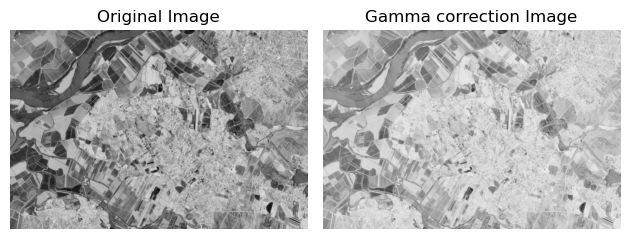

In [238]:
fig, axes = plt.subplots(1, 2)  

axes[0].imshow(band, cmap='gray')  
axes[0].set_title("Original Image")   
axes[0].axis('off')

axes[1].imshow(gamma_corrected, cmap='gray')  
axes[1].set_title("Gamma correction Image")   
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 4. Code the histogram equalization function

### Histogram computation and visualization

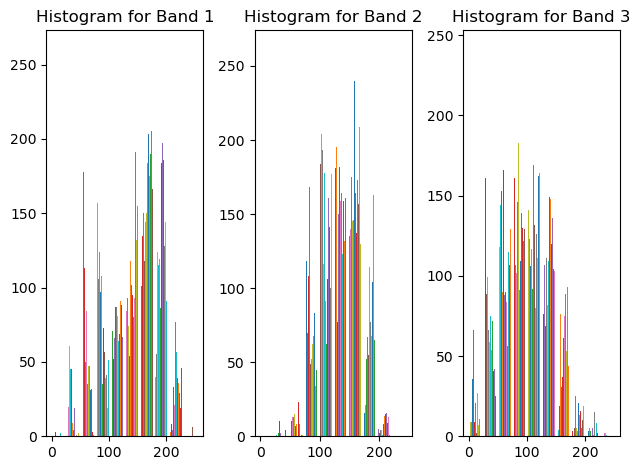

In [239]:
fig, axes = plt.subplots(1, 3)  

for i in range(3):  
    axes[i].hist(bands[i])  
    axes[i].set_title(f'Histogram for Band {i+1}')

plt.tight_layout()
plt.show()

### Cumulative histogram computation and visualization

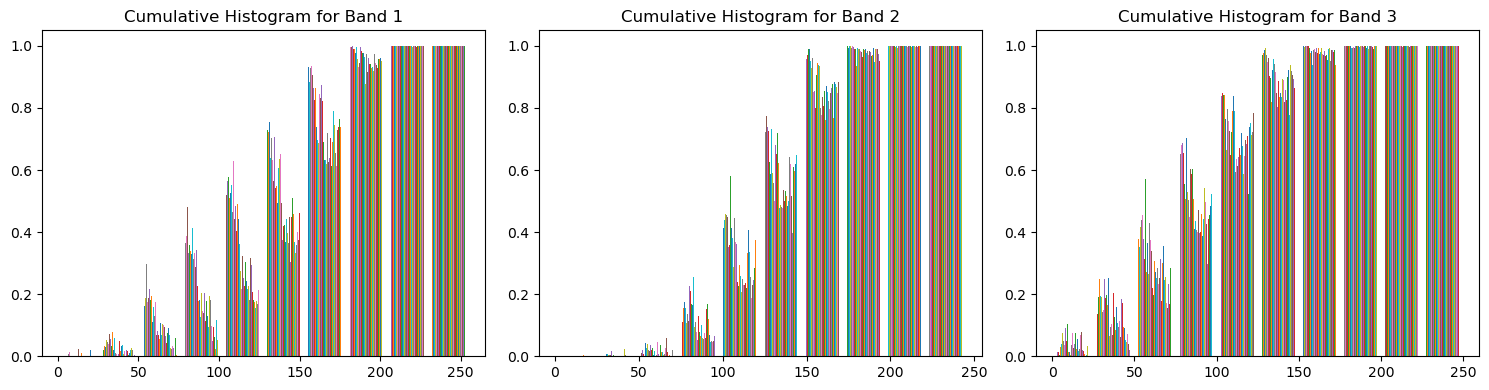

In [240]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  

for i in range(3):  
    axes[i].hist(bands[i], cumulative=True, density=True)  
    axes[i].set_title(f'Cumulative Histogram for Band {i+1}')

plt.tight_layout()
plt.show()

### Histogram equalization using CV2

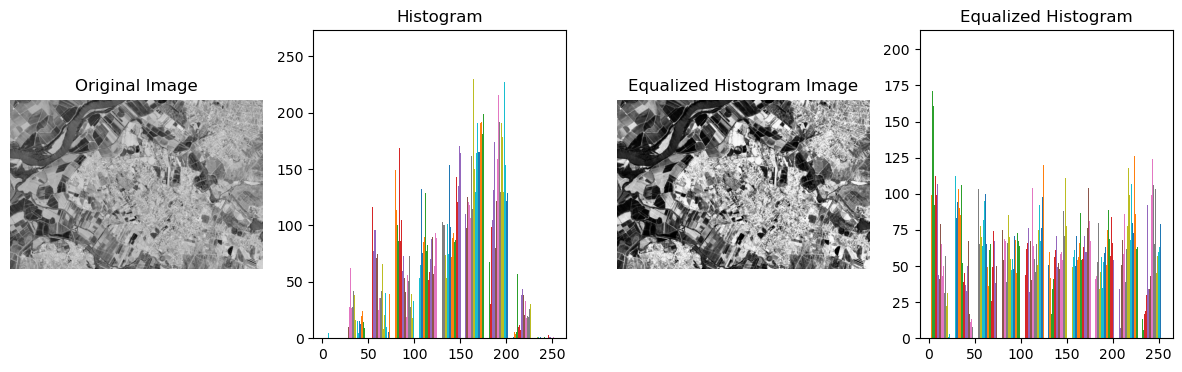

In [241]:
histeq = cv2.equalizeHist(band)

fig, axes = plt.subplots(1, 4, figsize=(15, 4))  

axes[0].imshow(band, cmap='gray')  
axes[0].set_title("Original Image")   
axes[0].axis('off')

axes[1].hist(band)  
axes[1].set_title("Histogram")   

axes[2].imshow(histeq, cmap='gray')  
axes[2].set_title("Equalized Histogram Image")   
axes[2].axis('off')

axes[3].hist(histeq)  
axes[3].set_title("Equalized Histogram") 

# plt.tight_layout()
plt.show()

## 5. Check if `histeq(negative(image))==negative(histeq(image))`

In [242]:
negative_image = negative_bands[1]
histeq_image = histeq

histeq_negative_image = ((255 - negative_image).astype(np.uint8))
negative_histeq_image = ((255 - histeq_image).astype(np.uint8))

if np.array_equal(histeq_negative_image, negative_histeq_image):
    print("Equal")
else:
    print("Not equal")

Not equal


## 6. Perform a contrast stretch clipping the 5% extrema

In [243]:
alfa = 5
low = alfa
high = 100 - alfa

percentile_low = np.percentile(band, low)
percentile_high = np.percentile(band, high)

clipped_band = np.clip(band, percentile_low, percentile_high)
clipped_band_rescale = ((clipped_band - percentile_low) / (percentile_high - percentile_low) * 255).astype(np.uint8)

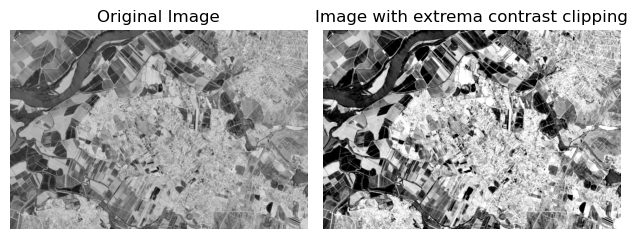

In [244]:
fig, axes = plt.subplots(1, 2)  

axes[0].imshow(band, cmap='gray')  
axes[0].set_title("Original Image")   
axes[0].axis('off')

axes[1].imshow(clipped_band_rescale, cmap='gray')  
axes[1].set_title("Image with extrema contrast clipping")   
axes[1].axis('off')

plt.tight_layout()
plt.show()

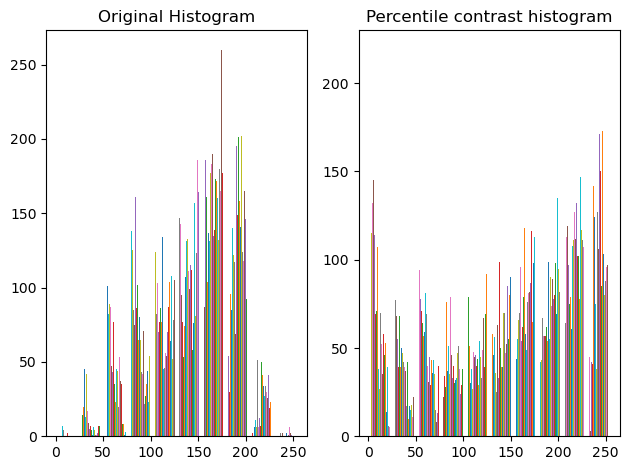

In [245]:
fig, axes = plt.subplots(1, 2)  

axes[0].hist(band)  
axes[0].set_title("Original Histogram")

axes[1].hist(clipped_band_rescale)
axes[1].set_title("Percentile contrast histogram")   

plt.tight_layout()
plt.show()

## 7. Play with multi-image operators (NDVI extraction)

In case you are using this image `_images/s2_lisbon_.jpg`, try to run the following cells to see how to compute NDVI.

In [246]:
red = rasterio.open("_images/red.jpg")
red = (red.read()).squeeze()
nir = rasterio.open("_images/nir.jpg")
nir = (nir.read()).squeeze()

In [247]:
n = 255
ndvi = ((((nir / n) - (red / n)) / ((nir / n) + (red / n)))* n).astype(np.uint8)

/var/folders/m1/jbwb10r115nghdm3qdhnjtnm0000gn/T/ipykernel_63250/2512522331.py:2: RuntimeWarning: invalid value encountered in divide
  ndvi = ((((nir / n) - (red / n)) / ((nir / n) + (red / n)))* n).astype(np.uint8)
/var/folders/m1/jbwb10r115nghdm3qdhnjtnm0000gn/T/ipykernel_63250/2512522331.py:2: RuntimeWarning: invalid value encountered in cast
  ndvi = ((((nir / n) - (red / n)) / ((nir / n) + (red / n)))* n).astype(np.uint8)


In [248]:
print("Maximum value for NDVI:", ndvi.max())
print("Minimum value for NDVI:", ndvi.min())

Maximum value for NDVI: 255
Minimum value for NDVI: 0


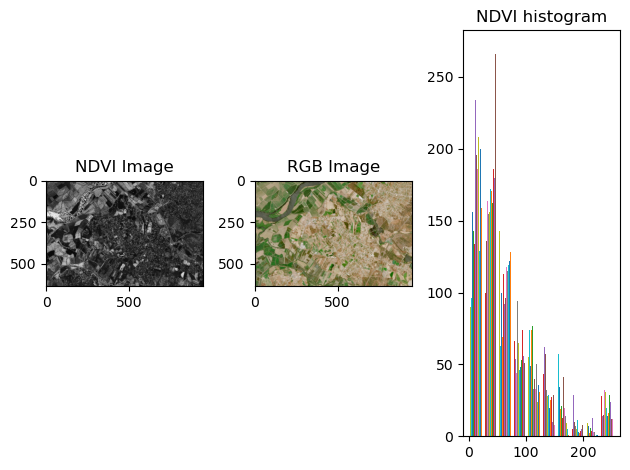

In [249]:
fig, axes = plt.subplots(1, 3)  

axes[0].imshow(ndvi, cmap='gray')  
axes[0].set_title("NDVI Image")

axes[1].imshow(rgb)  
axes[1].set_title("RGB Image")

axes[2].hist(ndvi)  
axes[2].set_title("NDVI histogram")

plt.tight_layout()
plt.show()